In [30]:
import os
import datetime

import numpy as np
import pandas as pd

from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import Point
import movingpandas as mpd

import matplotlib.pyplot as plt
import matplotlib as mlp
import scienceplots
plt.style.use("science")
import seaborn as sns

import folium as fl
from folium.plugins import FastMarkerCluster

from IPython.core.display_functions import clear_output

# Load Data

In [98]:
df = pd.read_csv("../data/1_france_data.csv")

In [99]:
df.head()

,BaseDateTime,LAT,LON,SOG,COG,Status,vessel
0,2015-12-16 09:31:35,48.381700,-4.471865,0.0,28.9,5.0,207138000
1,2015-12-16 09:31:45,48.381706,-4.471863,0.0,33.6,5.0,207138000
2,2015-12-16 09:31:54,48.381680,-4.471873,0.0,24.7,5.0,207138000
3,2015-12-16 09:32:05,48.381653,-4.471885,0.0,30.0,5.0,207138000
4,2015-12-16 09:32:15,48.381668,-4.471892,0.0,24.5,5.0,207138000


# Navigational Status Inconsistency

In [100]:
ais_inconsistent_status = df.loc[(df["Status"] == 5) & (df["SOG"] >= 1), ["LAT", "LON", "SOG"]]
ais_inconsistent_status_points = gpd.points_from_xy(ais_inconsistent_status["LON"],
                                                    ais_inconsistent_status["LAT"],
                                                    crs=4326)
gdf_ais_inconsistent_status = gpd.GeoDataFrame(ais_inconsistent_status,
                                               geometry=ais_inconsistent_status_points)

/var/folders/20/m3t9trt177390cx_80yzc8wc0000gn/T/ipykernel_8029/2595474547.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


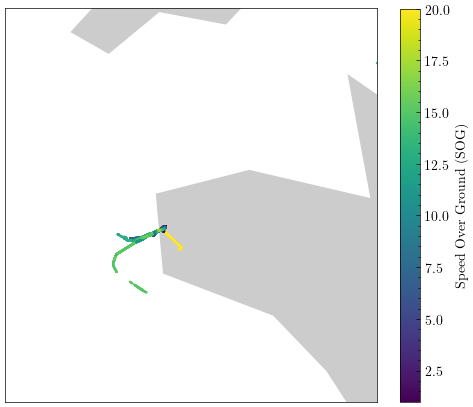

In [101]:
fig, ax = plt.subplots(figsize=(6, 6))
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.plot(ax=ax, alpha=0.4, color="grey")

legend_kwds = {
    "orientation": "vertical",
    "shrink": 0.85,
    "label": "Speed Over Ground (SOG)"
}
gdf_ais_inconsistent_status.plot(column="SOG", markersize=0.5, ax=ax,
                                 legend=True, legend_kwds=legend_kwds)
plt.xlim([gdf_ais_inconsistent_status["LON"].min() - 1.5,
          gdf_ais_inconsistent_status["LON"].max() + 0])
plt.ylim([gdf_ais_inconsistent_status["LAT"].min() - 1,
          gdf_ais_inconsistent_status["LAT"].max() + 0.5])
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])

plt.savefig("../figures/tese/metodos/nav_status_inconsistency_france")
plt.show()

# Split Voyages

In [102]:
ports = gpd.read_file("../data/france_data/[C1] Ports of Brittany/port.shp")
brest_port = ports[ports["libelle_po"] == "Brest"]
lon = brest_port.iloc[0]["geometry"].geoms[0].xy[0][0]
lat = brest_port.iloc[0]["geometry"].geoms[0].xy[1][0]

In [103]:
print(f"({lon}, {lat})")

(-4.475309812300752, 48.38273389573341)


In [104]:
berth_port_coords = [lat, lon-0.01]

In [129]:
df_clean = df.copy()

In [130]:
transformer = Transformer.from_crs(4326, 3857)
x, y = transformer.transform(df_clean["LAT"].to_numpy(), df_clean["LON"].to_numpy())

In [131]:
df_clean["x"] = x
df_clean["y"] = y

In [132]:
# Get the distance of each point to the port (defined by the quay point)
quay_point = Point(transformer.transform(berth_port_coords[0], berth_port_coords[1]))
distanceToPort = gpd.points_from_xy(df_clean.x, df_clean.y, crs=3857).distance(quay_point)
df_clean["distanceToPort"] = distanceToPort

In [133]:
# Get arrival point (first point within 4km of the quay center with
# Status = 5 and SOG < 1 knot)
df_clean["arrival_point"] = 0
df_clean.loc[(df_clean["distanceToPort"] < 3500)
             & (df_clean["Status"] == 5)
             & (df_clean["SOG"] < 1), "arrival_point"] = 1
points_after_arrival = (df_clean["arrival_point"].diff() != 1) \
                       & (df_clean["arrival_point"] == 1)
df_clean = df_clean.loc[~points_after_arrival, :]
df_clean.reset_index(drop=True, inplace=True)

In [134]:
# Enumerate voyages (where arrival_point = 1 subtract 1)
df_clean["voyage"] = df_clean.groupby("vessel")["arrival_point"].cumsum().values
df_clean.loc[df_clean["arrival_point"] == 1, "voyage"] -= 1

In [135]:
# map vessel ids to smaller numbers
vessel_id_map = pd.Series(data=np.arange(1, df_clean["vessel"].unique().shape[0]+1),
                          index=df_clean["vessel"].unique()).to_dict()

df_clean["vessel"] = df_clean["vessel"].map(vessel_id_map)

# Build vessel-voyage pairs (voyage ids)
df_clean["voyage_id"] = df_clean["vessel"].astype(str) + "-" \
                        + df_clean["voyage"].astype(str)

In [136]:
df_clean["BaseDateTime"] = pd.to_datetime(df_clean["BaseDateTime"])

In [137]:
# Get the remaining time from each msg to the arrival message (remaining voyage time)
remainingVoyageTime = df_clean.groupby("voyage_id") \
    .apply(lambda x: x.iloc[-1]["BaseDateTime"] - x.loc[:, "BaseDateTime"]) \
    .sort_index(level=1)
df_clean["remainingVoyageTime"] = (remainingVoyageTime.dt.total_seconds() / 60).values

In [138]:
# Take only msgs within 2 days of a vessel's arrival
df_clean = df_clean.loc[df_clean["remainingVoyageTime"] <= 48*60]

In [139]:
# Take only points at least 10 Km from the terminal location
df_clean = df_clean.loc[df_clean["distanceToPort"] >= 10000]

In [140]:
# Convert distance in meters to nautical miles
df_clean["distanceToPort"] *= 0.000539956803

In [141]:
m = fl.Map(location=berth_port_coords, zoom_start=8)

moored_points = df_clean.loc[(df_clean["Status"] == 5)
                             & (df_clean["SOG"] < 1.0), ["LAT", "LON"]]

fmc = FastMarkerCluster(data=moored_points.values)
fmc.add_to(m)

m

In [142]:
m = fl.Map(location=berth_port_coords, zoom_start=8)

anchored_points = df_clean.loc[(df_clean["Status"] == 1)
                               & (df_clean["SOG"] < 5.0), ["LAT", "LON"]]

fmc = FastMarkerCluster(data=anchored_points.values)
fmc.add_to(m)

m

In [145]:
# Remove messages until vessels leave the last port

# Moored points
df_clean = df_clean.groupby("voyage_id") \
    .apply(lambda x: x if x.loc[(x["Status"] == 5)
                                & (x["SOG"] < 1), "BaseDateTime"].max() is pd.NaT
                        else x[x["BaseDateTime"]
                               > (x.loc[(x["Status"] == 5)
                                        & (x["SOG"] < 1), "BaseDateTime"].max())]) \
                            .sort_index(level=1).reset_index(drop=True)

# Anchored points
df_clean = df_clean.groupby("voyage_id") \
    .apply(lambda x: x if x.loc[(x["Status"] == 1)
                                & (x["SOG"] < 5), "BaseDateTime"].max() is pd.NaT
                        else x[x["BaseDateTime"]
                            > (x.loc[(x["Status"] == 1)
                                        & (x["SOG"] < 5), "BaseDateTime"].max())]) \
                            .sort_index(level=1).reset_index(drop=True)

In [146]:
# Remove voyages with less than 100 msgs
invalid_voyages = df_clean["voyage_id"].value_counts() < 100
invalid_voyages = invalid_voyages[invalid_voyages].index.values
df_clean = df_clean.loc[~df_clean["voyage_id"].isin(invalid_voyages)]

In [147]:
df_clean["voyage_id"].value_counts().min()

148

In [148]:
df_clean["voyage_id"].unique().shape

(164,)

In [149]:
df_clean["vessel"].unique().shape

(66,)

# Visualize voyages

In [ ]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"), crs="EPSG:4326")
europe = world.query("continent == 'Europe'")

for voyage_id, voyage_data in df_clean.groupby("voyage_id"):

    trajectory = mpd.Trajectory(df=voyage_data,
                                traj_id=voyage_id,
                                t="BaseDateTime",
                                x="LON", y="LAT")

    fig, ax = plt.subplots(figsize=(5, 5))
    europe.plot(ax=ax, color="white", edgecolor="black")
    trajectory.plot(ax=ax)

    ax.set_xlim([voyage_data["LON"].min() - 2, voyage_data["LON"].max() + 2])
    ax.set_ylim([voyage_data["LAT"].min() - 2, voyage_data["LAT"].max() + 2])
    ax.set_title(f"Voyage {voyage_id}")
    plt.show()

    clear_output(wait=True)
    plt.pause(1)

/var/folders/20/m3t9trt177390cx_80yzc8wc0000gn/T/ipykernel_8029/1227284084.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"), crs="EPSG:4326")


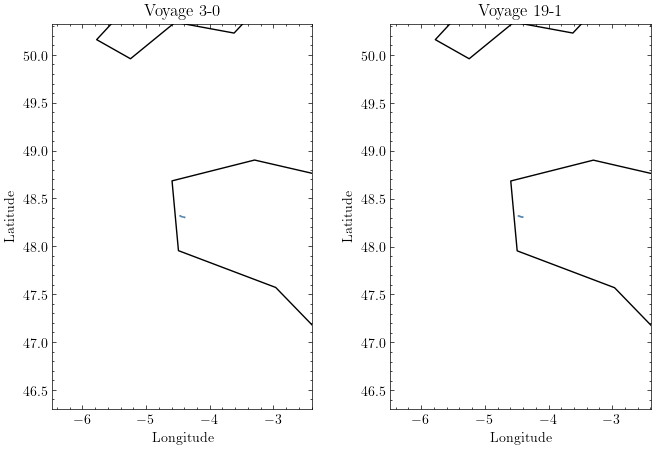

In [152]:
voyages_to_remove = ["3-0", "19-1"]

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"), crs="EPSG:4326")
europe = world.query("continent == 'Europe'")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

for i in range(0, 2):

    voyage_data = df_clean.loc[df_clean["voyage_id"] == voyages_to_remove[i],
                               ["voyage_id", "BaseDateTime", "LON", "LAT"]]
    
    trajectory = mpd.Trajectory(df=voyage_data,
                                traj_id="voyage_id",
                                t="BaseDateTime",
                                x="LON", y="LAT")

    europe.plot(ax=axs[i%2], color="white", edgecolor="black")
    trajectory.plot(ax=axs[i%2])
    axs[i%2].set_xlim([voyage_data["LON"].min() - 2, voyage_data["LON"].max() + 2])
    axs[i%2].set_ylim([voyage_data["LAT"].min() - 2, voyage_data["LAT"].max() + 2])
    axs[i%2].set_title(f"Voyage {voyage_data['voyage_id'].values[0]}")
    axs[i%2].set_ylabel("Latitude")
    axs[i%2].set_xlabel("Longitude")

plt.savefig("../figures/tese/metodos/app_rem_voyages_brest")
plt.show()

In [153]:
voyages_to_remove = ["3-0", "19-1"]

trajectories = mpd.TrajectoryCollection(data=df_clean[df_clean["voyage_id"].isin(voyages_to_remove)], 
                                        traj_id_col="voyage_id", t="BaseDateTime", x="LON", y="LAT", crs="epsg:4326")
    
m = fl.Map(width=500, height=500, location=berth_port_coords, zoom_start=8)

i = 0
for trajectory in trajectories.trajectories:
    coords = [[x[1], x[0]] for x in trajectory.to_linestring().coords]
    fl.PolyLine(coords, weight=2, opacity=1, popup=trajectory.id).add_to(m)
    i+=1
    
m

In [154]:
voyages_to_remove = ["3-0", "19-1"]

df_clean = df_clean[~df_clean["voyage_id"].isin(voyages_to_remove)]

In [155]:
df_clean["voyage_id"].unique().shape

(162,)

In [156]:
df_clean["vessel"].unique().shape

(66,)

/var/folders/20/m3t9trt177390cx_80yzc8wc0000gn/T/ipykernel_8029/4026697046.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"), crs="EPSG:4326")
/var/folders/20/m3t9trt177390cx_80yzc8wc0000gn/T/ipykernel_8029/4026697046.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.85)


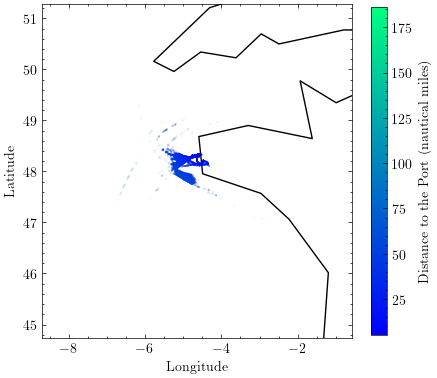

In [157]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"), crs="EPSG:4326")
europe = world.query("continent == 'Europe'")

cmap = mlp.colormaps.get_cmap("winter")

fig, ax = plt.subplots(figsize=(5,5))
europe.plot(ax=ax, color="white", edgecolor="black")

dist_norm = (df_clean["distanceToPort"] - df_clean["distanceToPort"].min()) \
            / (df_clean["distanceToPort"].max() - df_clean["distanceToPort"].min())

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(df_clean["distanceToPort"])
cbar = plt.colorbar(sm, shrink=0.85)

cbar.set_label("Distance to the Port (nautical miles)")

ax.scatter(df_clean["LON"], df_clean["LAT"], c=cmap(dist_norm), s=0.0001)

ax.set_xlim([df_clean["LON"].min() - 2, df_clean["LON"].max() + 2])
ax.set_ylim([df_clean["LAT"].min() - 2, df_clean["LAT"].max() + 2])
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")

plt.savefig("../figures/tese/metodos/final_brest_data")
plt.show()

In [158]:
df_clean = df_clean[["vessel", "voyage", "voyage_id",
                     "BaseDateTime", "LON", "LAT", "SOG", "COG",
                     "distanceToPort", "remainingVoyageTime",
                     "x", "y"]]

In [159]:
df_clean.head()

,vessel,voyage,voyage_id,BaseDateTime,LON,LAT,SOG,COG,distanceToPort,remainingVoyageTime,x,y
55,2,0,2-0,2016-01-01 20:53:16,-5.661688,48.435425,7.0,113.0,70.870211,1055.216667,-630256.258586,6.179602e+06
56,2,0,2-0,2016-01-01 20:53:28,-5.661258,48.435173,6.9,122.5,70.842872,1055.016667,-630208.357809,6.179560e+06
57,2,0,2-0,2016-01-01 21:33:29,-5.524507,48.398712,9.6,105.0,62.480487,1015.000000,-614985.261596,6.173444e+06
58,2,0,2-0,2016-01-01 21:33:36,-5.524189,48.398514,8.9,127.1,62.460960,1014.883333,-614949.850866,6.173411e+06
59,2,0,2-0,2016-01-01 21:33:58,-5.522910,48.398014,9.1,128.7,62.383112,1014.516667,-614807.528897,6.173327e+06


In [160]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186472 entries, 55 to 187313
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   vessel               186472 non-null  int64         
 1   voyage               186472 non-null  int64         
 2   voyage_id            186472 non-null  object        
 3   BaseDateTime         186472 non-null  datetime64[ns]
 4   LON                  186472 non-null  float64       
 5   LAT                  186472 non-null  float64       
 6   SOG                  186472 non-null  float64       
 7   COG                  186472 non-null  float64       
 8   distanceToPort       186472 non-null  float64       
 9   remainingVoyageTime  186472 non-null  float64       
 10  x                    186472 non-null  float64       
 11  y                    186472 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(2), object(1)
memory usage: 18.5+ MB

In [161]:
df_clean.to_csv("../data/2_france_voyages.csv", index=False)